# Apply Optical Transfer Function (OTF) Perturbations

pyBSM exposes a broad range of sensor parameters (e.g. focal length, aperture, pixel pitch, etc.) and scenario parameters (e.g. altitude, ground range, visibility, etc.) that you can perturb.

This section includes concrete, visualizable examples of perturbations based on the large set of Optical Transfer Function (OTF) parameters that pyBSM defines. OTF parameters can be "perturbed" to simulate different environmental and sensor-based effects.

Each OTF covered here includes a detailed summary, a test input image, and the perturbed result image, along with a code sample.

**For foundational theory, this [pyBSM explanation](https://pybsm.readthedocs.io/en/latest/explanation.html) provides further context into image formation concepts, OTFs, and their parameters.**

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/otf_visualization.ipynb)

## Set Up the Environment
Below is an example of an input image that will undergo a OTF perturbation. This image represents the initial state before any transformation.

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [ ]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q "nrtk[pybsm]"
print("Done")

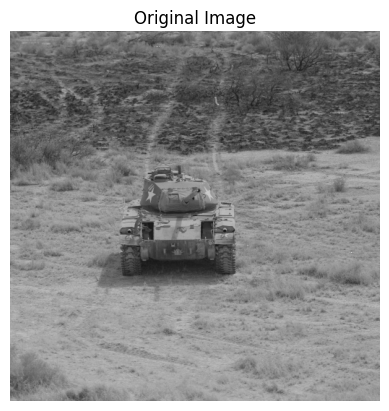

In [1]:
import os
import urllib.request

import cv2
import matplotlib.pyplot as plt
import numpy as np

data_dir = "pybsm/data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/6596fde89c30d6f4e17c9efc/download"

image_path = os.path.join(data_dir, "M-41 Walker Bulldog (USA) width 319cm height 272cm.tiff")
if not os.path.isfile(image_path):
    _ = urllib.request.urlretrieve(url, image_path)  # noqa: S310


image = np.asarray(cv2.imread(image_path))

fig, ax = plt.subplots()
ax.imshow(image)  # type: ignore
ax.set_title("Original Image")
ax.set_axis_off()  # type: ignore

We will also define a helper function for displaying the original image and the augmented side by side.

In [ ]:
def display_augmented_image(original_image: np.ndarray, augmented_image: np.ndarray, augmented_title: str) -> None:
    """Helper function to display the original image and augmented image."""
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(original_image)  # type: ignore
    ax[0].set_title("Original Image")
    ax[0].set_axis_off()  # type: ignore
    ax[1].imshow(augmented_image)  # type: ignore
    ax[1].set_title(augmented_title)
    ax[1].set_axis_off()  # type: ignore

## Circular Aperture OTF

The Circular Aperture OTF encompasses the diffraction effects from the circular aperture model. This is an
approximation for changes to the model such as changing the lens of the sensor.

Multispectral imaging captures light across several wavelength bands, typically ranging from the visible to the
infrared spectrum. These bands can be broadly categorized as visible, near-infrared (NIR), short-wave infrared
(SWIR), mid-wave infrared (MWIR), and long-wave infrared (LWIR). Each band provides unique information about
the scene, and the weights assigned to each band can be adjusted to optimize for specific applications.
The spectral weights determine the relative spectral contributions to the signal collected by a sensor. The
spectral weights are thus a 2 x N array where the first row (`mtf_wavelengths`) is a series of wavelength choices
and the second row (`mtf_weights`) is the relative contribution of the respective wavelengths to the signal.

Below is some example code that initializes and applies a `CircularApertureOTFPerturber`. To simulate different
circular aperture models, you can adjust the `mtf_wavelengths`, `mtf_weights`, `D`, and `eta` parameters. For additional
information on customizing the `CircularApertureOTFPerturber` for your own image, refer to the
[documentation](<project:../_implementations/nrtk.impls.perturb.optical.circular_aperture_otf_perturber.CircularApertureOTFPerturber.rst#nrtk.impls.perturb.optical.circular_aperture_otf_perturber.CircularApertureOTFPerturber>).

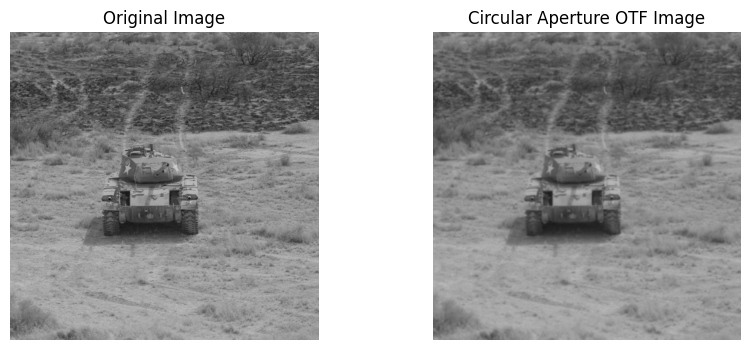

In [ ]:
import warnings

from nrtk.impls.perturb.optical.circular_aperture_otf_perturber import CircularApertureOTFPerturber

# There are multiple warnings that appear from calculating arccos and sqrt outside of their domains. This is
# expected and is handled appropriately, but we chose to ignore the warnings to simpilfy the output.
warnings.filterwarnings("ignore")

otf = CircularApertureOTFPerturber(mtf_wavelengths=[0.5e-6, 0.6e-6], mtf_weights=[0.5, 0.5], D=0.003, eta=0.0)
circular_aperture_otf_image, _ = otf.perturb(image)
display_augmented_image(image, circular_aperture_otf_image, "Circular Aperture OTF Image")

## Defocus OTF

The Defocus OTF simulates perturbations based on blur width. This is approximated as a Gaussian blur effect
quantified by variance in blur spot radii.

Below is some example code that initializes and applies a `DefocusOTFPerturber`. To simulate different levels of
defocus, you can adjust `w_x` and `w_y` parameters. `w_x` and `w_y` refer to the (Gaussian) blur spot radii in
the `x` and `y` axes respectively. A smaller radius indicates a more focused (centered) blur spot, whereas a
larger radius indicates a blur effect that is more spread out. You can adjust these parameters or use your own
image to visualize the perturbation and study the effect on image quality. For more information on customizing
`DefocusOTFPerturber`, see the
[documentation](<project:../_implementations/nrtk.impls.perturb.optical.defocus_otf_perturber.DefocusOTFPerturber.rst#nrtk.impls.perturb.optical.defocus_otf_perturber.DefocusOTFPerturber>).

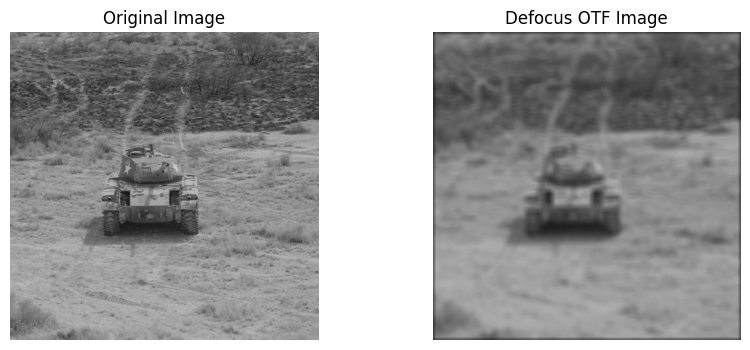

In [4]:
from nrtk.impls.perturb.optical.defocus_otf_perturber import DefocusOTFPerturber

otf = DefocusOTFPerturber(w_x=0.5, w_y=0.5)
defocus_otf_image, _ = otf.perturb(image)
display_augmented_image(image, defocus_otf_image, "Defocus OTF Image")

## Detector OTF

In imaging systems, a detector element (DEL) is a small, individual component that converts incident radiation
(e.g. X-rays, light, etc.) into an electrical signal, which is then used to create an image. These elements
are arranged in a matrix or array, forming the detector's overall (pixel) surface. The spatial resolution of a
detector system is directly related to the size of its detector elements or pixels. A detector with smaller
pixels can capture more detailed spatial information, while larger pixels cause blurring of fine details.

The Detector OTF simulates perturbations based on detector width; that is, blurring due to the spatial
integrating effects of the detector size. The width of a detector element along the x and y axes (`w_x` and
`w_y`) affects the spatial integration process. When photons from an image are detected, they are summed over
the area of the detector element. A wider element effectively integrates photons from a larger area,
which causes blurring of the output image.

Below is some example code that initializes and applies a `DetectorOTFPerturber`. To simulate different
detector sizes, you can adjust `w_x`, `w_y`, and `f` (focal length of detector) parameters. You can adjust
these parameters or use your own image to visualize the perturbation and study the effect on image quality.
For more information on customizing `DetectorOTFPerturber`, see the
[documentation](<project:../_implementations/nrtk.impls.perturb.optical.detector_otf_perturber.DetectorOTFPerturber.rst#nrtk.impls.perturb.optical.detector_otf_perturber.DetectorOTFPerturber>).

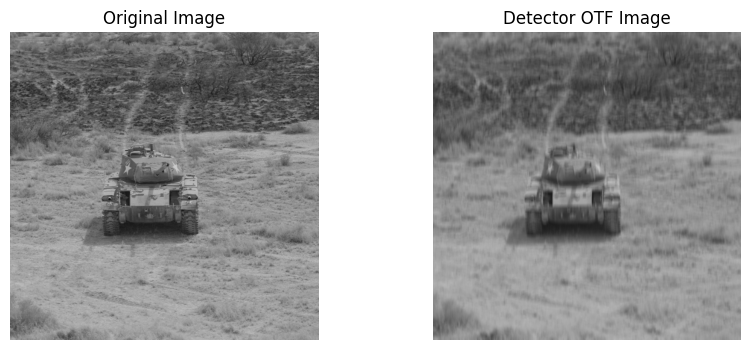

In [5]:
from nrtk.impls.perturb.optical.detector_otf_perturber import DetectorOTFPerturber

otf = DetectorOTFPerturber(w_x=3e-6, w_y=20e-6, f=30e-3)
detector_otf_image, _ = otf.perturb(image)
display_augmented_image(image, detector_otf_image, "Detector OTF Image")

## Jitter OTF

Jitter refers to small, rapid, unintended displacements of the imaging system (or its components) during
image acquisition. The Jitter OTF is modeled as a zero mean, Gaussian random process.

The higher the jitter, the narrower the Jitter OTF in frequency space. This suppresses high-frequency components,
leading to blurring of edges, loss of fine texture, and reduced contrast.

Below is some example code that initializes and applies a `JitterOTFPerturber`. To simulate different levels
of jitter intensity, you can adjust `s_x` and `s_y` parameters, which represent the standard deviation of the
system's positional error due to motion in the `x` and `y` direction, respectively. You can adjust these parameters
or use your own image to visualize the perturbation and study the effect on image quality. For more information on
customizing `JitterOTFPerturber`, see the
[documentation](<project:../_implementations/nrtk.impls.perturb.optical.jitter_otf_perturber.JitterOTFPerturber.rst#nrtk.impls.perturb.optical.jitter_otf_perturber.JitterOTFPerturber>).

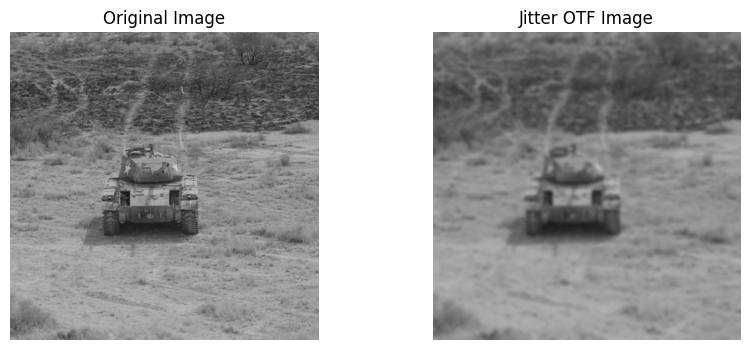

In [ ]:
from nrtk.impls.perturb.optical.jitter_otf_perturber import JitterOTFPerturber

otf = JitterOTFPerturber(s_x=2e-4, s_y=2e-4)
jitter_otf_image, _ = otf.perturb(image)
display_augmented_image(image, jitter_otf_image, "Jitter OTF Image")

## Turbulence Aperture OTF

The Turbulence Aperture OTF degrades an image by simulating atmospheric turbulence and optical aperture effects.

Below is some example code that initializes and applies a `TurbulenceApertureOTFPerturber`. To simulate different
atmospheric turbulence and optical aperture effects, you can adjust the following parameters:

- `mtf_wavelengths` - List of multispectral wavelength bands (m).
- `mtf_weights` - List of weights assigned to the corresponding wavelength bands to indicate relative
contribution to the overall signal (arbirtary value between 0.0 and 1.0).
- `altitude` - Sensor height above ground level (m).
- `slant_range` - Line-of-sight range between the aircraft and target, where the target is assumed to be on the
ground.
- `D` - Sensor's effective aperture diameter (m).
- `ha_wind_speed` - The high altitude windspeed (m/s).
- `cn2_at_1m` - The refractive index structure parameter "near the ground" (e.g. at h = 1 m); used to
calculate the turbulence profile. The default, 1.7e-14, is the Hufnagel-Valley (HV) 5/7 profile value.
- `int_time` - Integration time: The period during which a sensor accumulates incoming signals, such as light
or voltage, to measure a specific value (seconds).
- `n_tdi` - The number of time-delay integration stages (relevant only when TDI cameras are used; for CMOS
cameras, the value can be assumed to be 1.0).
- `aircraft_speed` - Apparent atmospheric velocity of the aircraft mounted with the sensor (m/s); this can
just be the windspeed at the sensor position if the sensor is stationary.

You can adjust these parameters or use your own image to visualize the perturbation and study the effect on image
quality. For more information on customizing `TurbulenceApertureOTFPerturber`, see the
[documentation](<project:../_implementations/nrtk.impls.perturb.optical.turbulence_aperture_otf_perturber.TurbulenceApertureOTFPerturber.rst#nrtk.impls.perturb.optical.turbulence_aperture_otf_perturber.TurbulenceApertureOTFPerturber>).

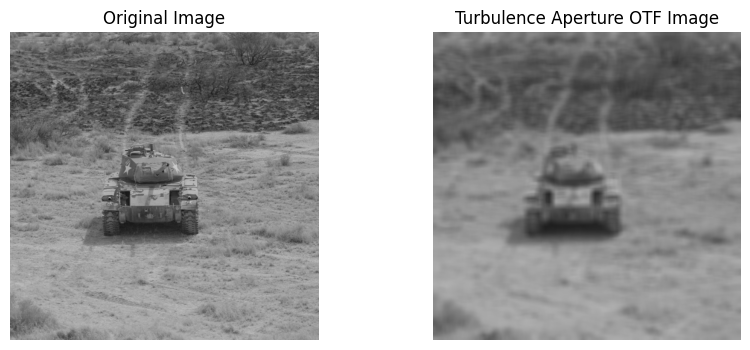

In [7]:
from nrtk.impls.perturb.optical.turbulence_aperture_otf_perturber import TurbulenceApertureOTFPerturber

otf = TurbulenceApertureOTFPerturber(
    mtf_wavelengths=[0.50e-10, 0.66e-10],
    mtf_weights=[1.0, 1.0],
    altitude=250,
    slant_range=250,
    D=40e-3,
    ha_wind_speed=0,
    cn2_at_1m=1.7e-14,
    int_time=30e-3,
    n_tdi=1.0,
    aircraft_speed=0,
)
turbulence_aperture_otf_image, _ = otf.perturb(image)
display_augmented_image(image, turbulence_aperture_otf_image, "Turbulence Aperture OTF Image")